In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

In [2]:
random.seed = 20

#### Load training dataset

In [3]:
# Root
from MyDataset import MyDataset

root = '../../train_val_test_dataset/IEEE_Case118/DL'

# Load all data with empty input
dataset = MyDataset(root=root, data_list=[])

In [4]:
# Get train dataset
train_size = 700

train_dataset = dataset[:train_size]

# Create train loader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [5]:
from GNNLoadRegressor import GNNLoadRegressor

In [6]:
# Set hyper-parameters
input_dim1 = 20
input_dim2 = 44
hidden_dim1 = 44
hidden_dim2 = 32
output_dim1 = 32
output_dim2 = 12

# Set device
device = 'gpu' if torch.cuda.is_available() else 'cpu'

# Initialize the model
model = GNNLoadRegressor(input_dim1, input_dim2, hidden_dim1, hidden_dim2, output_dim1, output_dim2)
model.to(device)

GNNLoadRegressor(
  (ann): Sequential(
    (0): Linear(in_features=44, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
    (5): ReLU()
  )
)

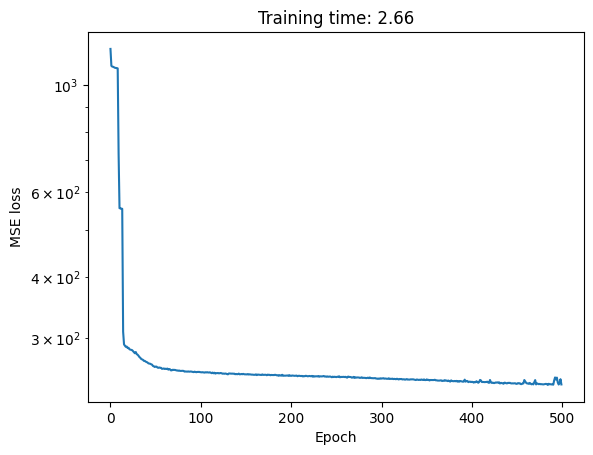

In [7]:
# Set number of epochs
epochs = 500

# Set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Set model to training mode
model.train()

# Model training and validation
epoch_loss = []
start_time = time.time()
for epoch in range(epochs):
    batch_loss = []
    for loader in train_loader:
        loader.to(device)

        optimizer.zero_grad()

        y_pred = model(loader.x, loader.edge_index)

        loss = F.mse_loss(y_pred, loader.y)

        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    epoch_loss.append(np.mean(batch_loss))

end_time = time.time()
training_time = (end_time - start_time)/60

plt.plot(epoch_loss)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title(f'Training time: {training_time:.2f}')
plt.show()
plt.close('all')

In [8]:
torch.save(model, './trained_model/DL_model.pt')

#### Model testing

In [9]:
# Get train dataset
test_size = 200

test_dataset = dataset[-test_size:]

# Create train loader
############ Shuffle cannot be true for testing data ##############
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [10]:
model.eval()

with torch.no_grad():
    for i, loader in enumerate(test_loader):
        # Get ground true
        ground_true = loader.y.detach().numpy()
        ground_true = np.round(ground_true, 2)
        # Save ground true
        file_path = f'./model_evaluation/DL_true/true_{i+1}.csv'
        pd.DataFrame(ground_true).to_csv(file_path, columns=None, index=None, header=None)

        # Get prediction
        pred = model(loader.x, loader.edge_index)
        pred = pred.detach().numpy()
        pred = np.round(pred, 2)

        # Save prediction
        file_path = f'./model_evaluation/DL_pred/pred_{i+1}.csv'
        pd.DataFrame(pred).to_csv(file_path, columns=None, index=None, header=None)